In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%pip install textblob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
!rm -rf ./logs/ 
!mkdir ./logs/

# Ignore Error

In [3]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook 

# Import Library

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import and download library for text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random
seed = 101
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [5]:
path = '/kaggle/input/emotions-dataset-for-nlp/'
train_path = path+'train.txt'
test_path = path+'test.txt'
val_path = path+'val.txt'

In [6]:
train_df = pd.read_csv(train_path, sep=';', names=['text', 'labels'])
test_df = pd.read_csv(test_path, sep=';', names=['text', 'labels'])
val_df = pd.read_csv(val_path, sep=';', names=['text', 'labels'])
full_df = pd.concat([train_df, test_df, val_df], axis=0)

In [7]:
print("Train text size", train_df.shape[0])
print("Test text size", test_df.shape[0])
print("Val text size", val_df.shape[0])
print("\nTotal samples", (train_df.shape[0]+test_df.shape[0]+val_df.shape[0]))

Train text size 16000
Test text size 2000
Val text size 2000

Total samples 20000


# Explanatory Data Analysis

In [8]:
def describe_data(data_type,data,label):
    print(data_type," DESCRIPTION")
    print("--------------------------")
    size=data.shape
    null_values=data.isnull().sum().sum()
    
    
    print(data_type," shape:",size,"\n")
    print(data_type," contains:",null_values," null values\n")
    print("Label counts:")  
    print(data[label].value_counts())
    print()
    
    print("*****",data_type," label count plot ****")
    sns.countplot(
        data=data,
        x=label
    )

Training Data  DESCRIPTION
--------------------------
Training Data  shape: (16000, 2) 

Training Data  contains: 0  null values

Label counts:
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: labels, dtype: int64

***** Training Data  label count plot ****


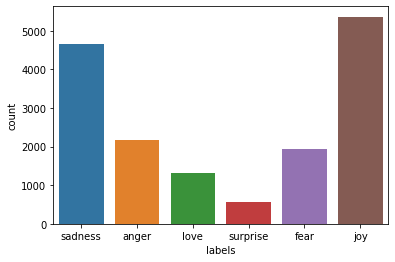

In [9]:
describe_data('Training Data', train_df, 'labels')

Test Data  DESCRIPTION
--------------------------
Test Data  shape: (2000, 2) 

Test Data  contains: 0  null values

Label counts:
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: labels, dtype: int64

***** Test Data  label count plot ****


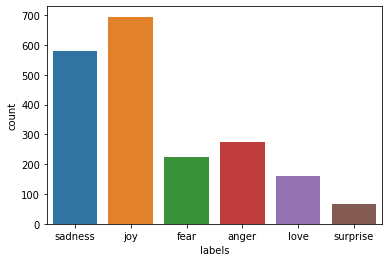

In [10]:
describe_data('Test Data', test_df, 'labels')

Val Data  DESCRIPTION
--------------------------
Val Data  shape: (2000, 2) 

Val Data  contains: 0  null values

Label counts:
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: labels, dtype: int64

***** Val Data  label count plot ****


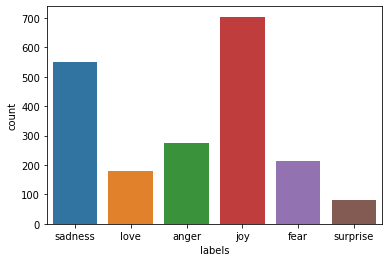

In [11]:
describe_data('Val Data', val_df, 'labels')

Full Data  DESCRIPTION
--------------------------
Full Data  shape: (20000, 2) 

Full Data  contains: 0  null values

Label counts:
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: labels, dtype: int64

***** Full Data  label count plot ****


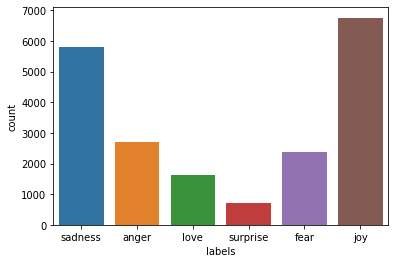

In [12]:
describe_data('Full Data', full_df, 'labels')

In [13]:
train_df['Length'] = train_df.text.apply(lambda x:len(x))

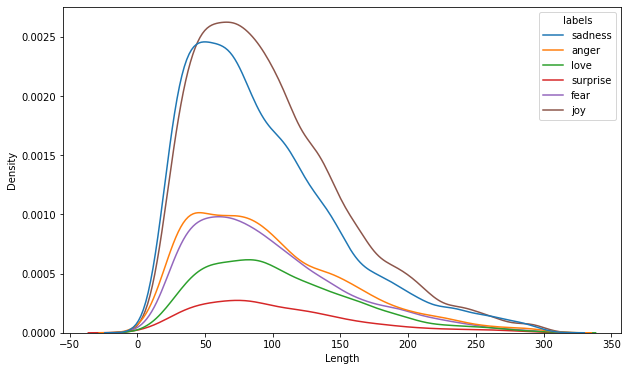

In [14]:
fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=train_df['Length'],
    hue=train_df["labels"]
)
plt.show()

In [15]:
print(train_df.Length.max())
print(train_df.Length.min())

300
7


In [16]:
train_df[['Length']].describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


# Data Preparation

In [17]:
def label_encode(data,label):
    labels=data[label].map(
    {
        "joy":0,
        "sadness":1,
        "anger":2,
        "fear":3,
        "love":4,
        "surprise":5
    }
    )
    return labels

labels = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [18]:
train_df['enc_labels'] = label_encode(train_df, 'labels')
test_df['enc_labels'] = label_encode(test_df, 'labels')
val_df['enc_labels'] = label_encode(val_df, 'labels')

In [19]:
train_df.head()

,text,labels,Length,enc_labels
0,i didnt feel humiliated,sadness,23,1
1,i can go from feeling so hopeless to so damned...,sadness,108,1
2,im grabbing a minute to post i feel greedy wrong,anger,48,2
3,i am ever feeling nostalgic about the fireplac...,love,92,4
4,i am feeling grouchy,anger,20,2


# Text Preparation

In [20]:
def lower_text(text):
    # lowercase the text 
    return text.lower()

def remove_number(text):
    # remove number with regex
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    # remove punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def nltk_process(text):
    list1 = word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(words) for words in list1])
    list1 = word_tokenize(text)
    text = " ".join([word for word in list1 if word not in (stopwords)])
    return text

def data_preparation(text):
    text = lower_text(text)
    text = remove_number(text)
    text = nltk_process(text)
    text = remove_punct(text)
  
    return text

In [21]:
train_df["clean_text"] = train_df["text"].apply(data_preparation)
test_df["clean_text"] = test_df["text"].apply(data_preparation)
val_df["clean_text"] = val_df["text"].apply(data_preparation)

In [22]:
train_df['Clean_Length'] = train_df['clean_text'].apply(lambda x:len(x))

In [23]:
train_df.head(10)

,text,labels,Length,enc_labels,clean_text,Clean_Length
0,i didnt feel humiliated,sadness,23,1,didnt feel humiliated,21
1,i can go from feeling so hopeless to so damned...,sadness,108,1,go feeling hopeless damned hopeful around some...,60
2,im grabbing a minute to post i feel greedy wrong,anger,48,2,im grabbing minute post feel greedy wrong,41
3,i am ever feeling nostalgic about the fireplac...,love,92,4,ever feeling nostalgic fireplace know still pr...,52
4,i am feeling grouchy,anger,20,2,feeling grouchy,15
5,ive been feeling a little burdened lately wasn...,sadness,65,1,ive feeling little burdened lately wasnt sure wa,48
6,ive been taking or milligrams or times recomme...,surprise,122,5,ive taking milligram time recommended amount i...,94
7,i feel as confused about life as a teenager or...,fear,73,3,feel confused life teenager jaded year old man,46
8,i have been with petronas for years i feel tha...,joy,98,0,petronas year feel petronas ha performed well ...,62
9,i feel romantic too,love,19,4,feel romantic,13


# Text Tokenizer

In [24]:
X_train = train_df['clean_text']
X_test = test_df['clean_text']
y_train = train_df['enc_labels']
y_test = test_df['enc_labels']
y_val = val_df['enc_labels']

In [25]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(val_df['clean_text'])

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

13464


In [26]:
X_train = pad_sequences(X_train, padding='post', maxlen=128)
X_test = pad_sequences(X_test, padding='post', maxlen=128)
X_val = pad_sequences(X_val, padding='post', maxlen=128)

In [27]:
OHE_y_test = to_categorical(y_test) # One Hot Encode apply
OHE_y_train = to_categorical(y_train)
OHE_y_val = to_categorical(y_val)

# Model Building

In [28]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

In [29]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=128, name='in_layer'),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(512, return_sequences=True, name='Bi-LSTM-1')),
    Bidirectional(LSTM(256, return_sequences=True, name='Bi-LSTM-2')),
    Bidirectional(LSTM(128, name='Bi-LSTM-3')),
    Dropout(0.5),
    Dense(512, activation='relu', name='fc-1'),
    Dense(6, activation='softmax', name='out_layer')
])

2023-01-24 17:05:16.069174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 17:05:16.190348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 17:05:16.191208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 17:05:16.193026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
# # tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)
class callbackTarget(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.92 and logs.get('accuracy') >= 0.92):
      print('\nVal_accuracy and accuracy has reached >= 92%!')
      self.model.stop_training = True

target = callbackTarget()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (Embedding)         (None, 128, 128)          1723392   
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 1024)         2625536   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 512)          2623488   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

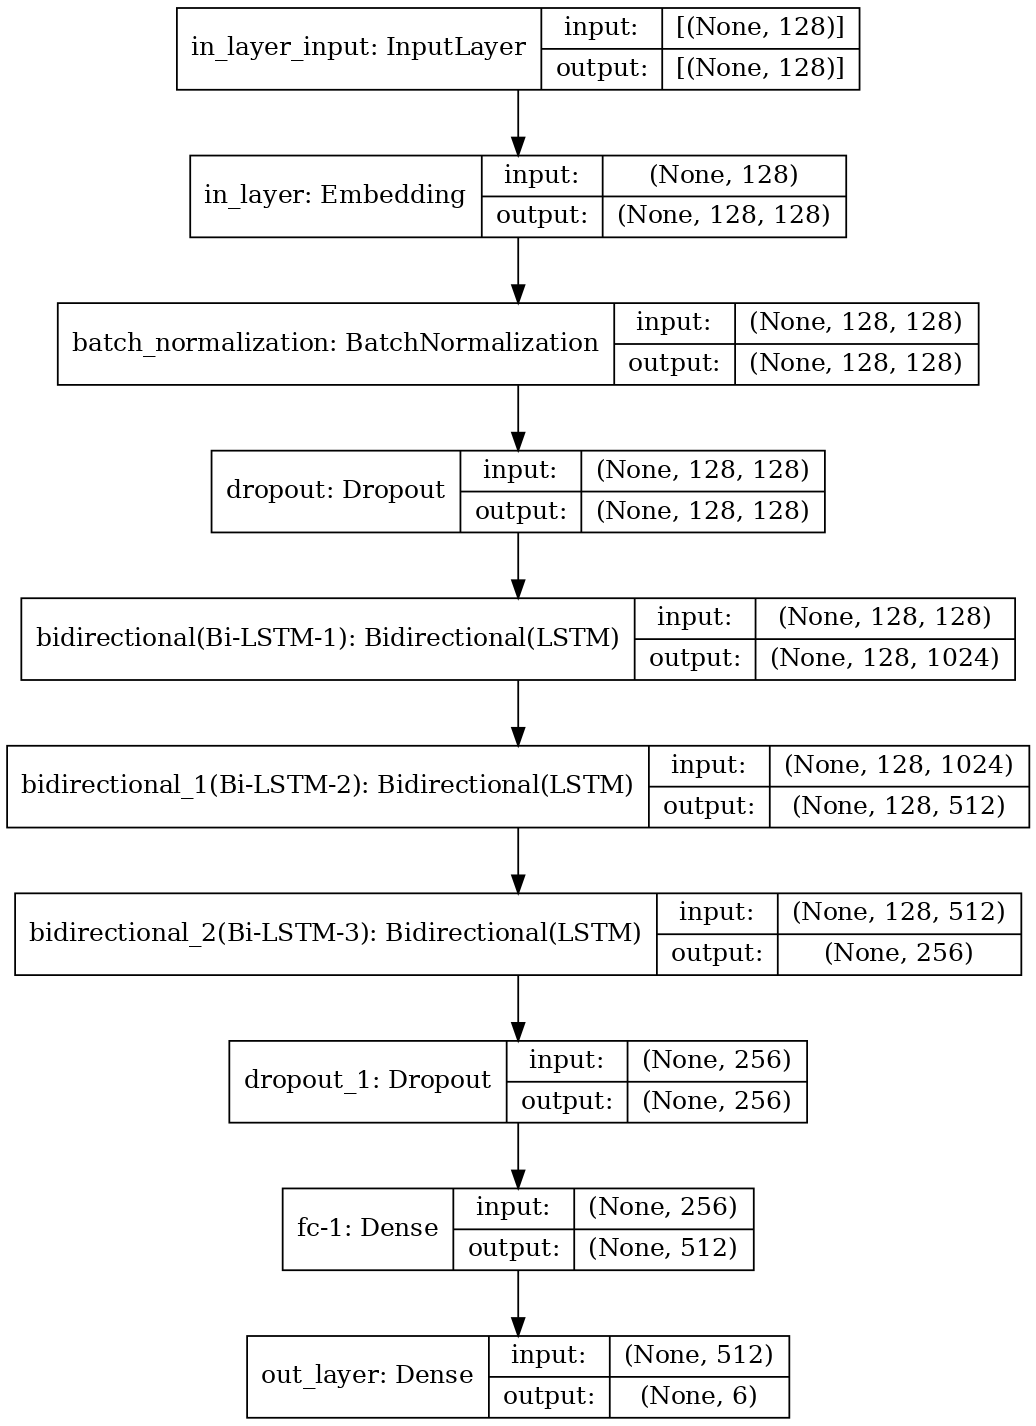

In [32]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', dpi=128, show_shapes=True, show_layer_names=True)

In [33]:
# Adam(learning_rate=0.0001)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, OHE_y_train,
                    epochs=200, 
                    verbose=1,
                    validation_data=(X_test, OHE_y_test),
                    callbacks = [checkpoint, reduce_lr, target],
                    batch_size=128)

2023-01-24 17:05:21.647668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-01-24 17:05:28.281228: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 32s 190ms/step - loss: 1.1670 - accuracy: 0.5453 - val_loss: 1.3105 - val_accuracy: 0.5995

Epoch 00001: val_accuracy improved from -inf to 0.59950, saving model to model.h5
Epoch 2/200
125/125 [==============================] - 22s 176ms/step - loss: 0.2752 - accuracy: 0.9056 - val_loss: 0.7414 - val_accuracy: 0.8310

Epoch 00002: val_accuracy improved from 0.59950 to 0.83100, saving model to model.h5
Epoch 3/200
125/125 [==============================] - 22s 176ms/step - loss: 0.1427 - accuracy: 0.9406 - val_loss: 0.3102 - val_accuracy: 0.9015

Epoch 00003: val_accuracy improved from 0.83100 to 0.90150, saving model to model.h5
Epoch 4/200
125/125 [==============================] - 22s 176ms/step - loss: 0.1104 - accuracy: 0.9535 - val_loss: 0.1803 - val_accuracy: 0.9280

Epoch 00004: val_accuracy improved from 0.90150 to 0.92800, saving model to model.h5

Val_accuracy and accuracy has reached >= 92%!


# Evaluation

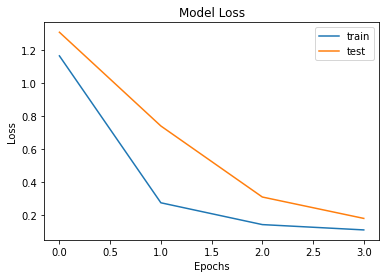

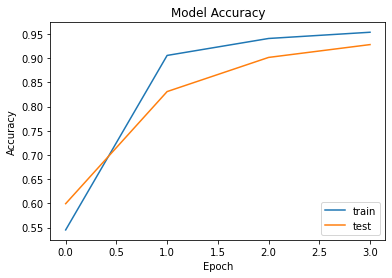

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [35]:
# model.evaluate(X_val, OHE_y_val)

In [36]:
# Model Evaluate with test df
predict = model.predict(X_val)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(val_df["enc_labels"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.96      0.94      0.95       704
        fear       0.97      0.97      0.97       550
         joy       0.89      0.94      0.92       275
        love       0.89      0.86      0.88       212
     sadness       0.82      0.93      0.87       178
    surprise       0.95      0.73      0.83        81

    accuracy                           0.93      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.93      0.93      0.93      2000



In [38]:
print(labels)
def get_key(value):
    dictionary={
        "joy":0,
        "sadness":1,
        "anger":2,
        "fear":3,
        "love":4,
        "surprise":5
    }
    for key,val in dictionary.items():
          if (val==value):
            return key

['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']


In [39]:
def predict_test(sentence):
  sentence_lst=[]
  sentence_lst.append(sentence)
  sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
  sentence_padded=pad_sequences(sentence_seq,maxlen=300,padding='post')
  ans=get_key(np.argmax(model.predict(sentence_padded), axis=1))
  print("The emotion predicted is",ans)

In [40]:
# predict(str(input('Enter a sentence : ')))
test_love = "i feel like a faithful servant"
test_anger = "i am just feeling cranky and blue"
test_joy = "i feel less keen about the army every day"
test_sadness = "i feel dirty and ashamed for saying that"
test_fear = " i spent a lot of time feeling overwhelmed with the amount of information he provided while reading the textbook"
test_love_2 = "i sincerely feel will benefit any relationship whether it is romantic family work or socially oriented"


predict_test(test_love)
predict_test(test_love_2)
predict_test(test_anger)
predict_test(test_joy)
predict_test(test_sadness)
predict_test(test_fear)

The emotion predicted is love
The emotion predicted is love
The emotion predicted is anger
The emotion predicted is joy
The emotion predicted is sadness
The emotion predicted is fear


In [41]:
pd.options.display.max_colwidth = 300

In [42]:
print(val_df['text'][val_df['labels']=='love'])

2                                                                                                                                                                                                     i feel like a faithful servant
18      i also loved that you could really feel the desperation in these sequences and i especially liked the emotion between knight and squire as theyve been together in a similar fashion to batman and robin for a long time now
30                                                                                                             i feel like im caring about my body not in just an attempt to be the right size but to feel good and have a full life
40                                                                    i sit the chicken preferably bone in chicken thighs skinless because i feel they have the most flavor in a crock pot so that it becomes tender and falls apart
48                                           i see the starlight caress your hair no